<a href="https://colab.research.google.com/github/Kharinaev/drug_consumption/blob/main/Drug_consumption_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ задачи
**Цель** - определить, зависим ли человек от различных легальных и нелегальных препаратов и продуктов, на основе разнообразных признаков, в том числе, психологических

**Где такая задача может быть применима?**

Знание о возможных зависимостях человека может пригодиться при найме сотрудников критически важные объекты, силовые структуры, на отвественные места в предприятиях (например, управленческие должности)

С этой точки зрения, ошибки FN опаснее, чем FP. Т.к. при ошибке FP возможны либо какие-то медицинские тесты, либо более тщательная психологическая проверка, либо просто отказ в устройстве на работу, а при ошибке FN - есть вероятность, что такой сотрудник может подвести, что опасно в силу критической важности его работы

Поэтому в качестве метрики для данной адачи логично взять **sensitivity** (recall)

Но зависимости от разных препаратов и продуктов из этого списка обладают разными рисками для здоровья, внимания, трудоспособности и т.д. Поэтому нужно задать веса, с которыми будут усредняться значения метрики для каждого целевого признака. (например, для кофе и шоколада - 1, для сигарет - 3, для тяжелых наркотиков, таких, как героин, метамфетамин и т.п. - 10)

# Необходимые импорты

In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
from sklearn.feature_selection import chi2

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

# Загрузка данных

Описание датасета: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

In [4]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data
df = pd.read_csv('drug_consumption.data', header=None, index_col=0)
df.columns = ['age', 'gender', 'education', 'country', 'ethnicity', 'Nscore', 
                'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsivness', 'SS',
                'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis',
                'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',
                'LegalH', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']
df.head()

,age,gender,education,country,ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


# Чистка данных

Отбросим ложные записи с теми респондентами, кто отвечал положительно на использование выдуманного наркотика "Semeron"  
Разделим датасет на признаковый и целевой

In [5]:
if 'Semer' in df.columns:
  df = df[df['Semer']=='CL0'].drop('Semer', axis=1)
target_cols = df.columns[list(range(12,30))]
target = df[target_cols]
data = df.drop(target_cols, axis=1)

# Обработка целевых признаков

Бинаризируем целевые данные, как указано в описании к датасету: если препарат принимался менее 10 лет назад - 1 - "User", иначе - 0 - "Non-user". Порог можно варьировать в зависимости от того, насколько строгим должен быть контроль

In [6]:
replace_dict = dict()
for i in range(7):
  replace_dict[f'CL{i}'] = int(i>1) 
target = target.replace(to_replace=replace_dict)

Рассмотрим баланс классов в целевых признаках

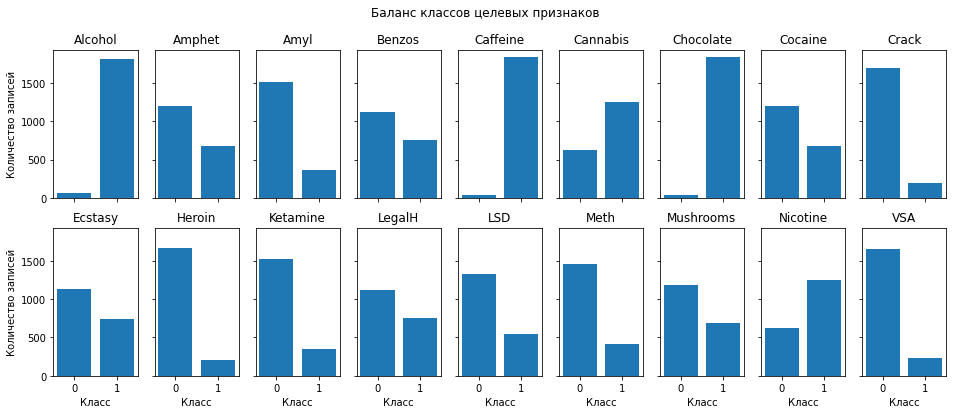

In [ ]:
fig, axs = plt.subplots(2,9, figsize=(16,6), sharex=True, sharey=True)
fig.suptitle('Баланс классов целевых признаков')

for i in range(2):
  for j in range(9):
    axs[i,j].bar(target.iloc[:,9*i+j].value_counts().index, height=target.iloc[:,9*i+j].value_counts().values)
    axs[i,j].set_title(f'{target.columns[9*i+j]}')
    axs[i,j].set_xlabel('Класс')
    axs[i,j].set_ylabel('Количество записей');

for ax in axs.flat:
    ax.label_outer()

Классы несбалансированы, это стоит учитывать при обучении моделей - использовать сбалансированные веса

# Отбор категориальных признаков

Выберем категориальные признаки (признак 'age' взят в качестве категориального, т.к. в датасете закодированы целые диапазоны возрастов, а не номинальные значения)

In [7]:
cat_features = data.columns[:5]
cat_features

Index(['age', 'gender', 'education', 'country', 'ethnicity'], dtype='object')

Для отбора признаков воспользуемся критерием Хи-квадрат. Установим высокий уровень значимости $\alpha$ = 0.25, т.к. критерий оценивает зависимость каждого признака и целевой переменной по отдельности, но, может быть, они дают зависимость в совокупности

Преобразуем данные в неотрицательные так, чтобы сохранились категории

In [8]:
non_neg = data[cat_features] - np.min(data[cat_features], axis=0) 
all(non_neg.nunique() == data[cat_features].nunique()) #совпадают ли количества уникальных значений во всех столбцах?

True

In [9]:
alpha = 0.25
array_p_values = []
for col in target.columns:
  array_p_values.append(chi2(non_neg, target[col])[1])
array_p_values = np.array(array_p_values)
p_values = np.mean(array_p_values, axis=0)

print(f'p-values: {[f"{i:0.4f}" for i in p_values]}\n')

print('p-value > alpha')
for f,p in zip(cat_features, p_values):
  print(f'"{f}"{" "*(10-len(f))}: {p>alpha}')

p-values: ['0.0083', '0.1229', '0.1708', '0.0219', '0.5557']

p-value > alpha
"age"       : False
"gender"    : False
"education" : False
"country"   : False
"ethnicity" : True


Для первых четырех признаков нулевая гипотеза о независимости с целевой переменной отвергается, для признака "ethnicity" этого сделать нельзя, удалим его из датасета

In [10]:
if 'ethnicity' in cat_features: 
  cat_features = cat_features.drop('ethnicity')
if 'ethnicity' in data.columns:
  data = data.drop('ethnicity', axis=1)

# Кодирование категориальных переменных

Рассмотрим количество уникальных значений категориальных переменных

In [11]:
data[cat_features].nunique()

age          6
gender       2
education    9
country      7
dtype: int64

Т.к. их немного, то удобно использовать One-hot encoder.   

Создадим 2 копии датасета, в одном категориальные переменные закодируем, в другом изменим тип данных на category для колонок с категориальными переменными, чтобы использовать для алгоритом, которые умеют работать с категориальными переменными

In [12]:
types_dict = {}
for f in cat_features: 
  types_dict[f] = 'category'

data_cat = data.astype(types_dict)
data_ohe = pd.get_dummies(data, columns=cat_features)

# Разбиение данных

Разобьем каждый датасет на обучающую и тестовую выборки

In [13]:
X_train_cat, X_test_cat, y_train, y_test = train_test_split(data_cat, target, test_size = 0.2, random_state = 0)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(data_ohe, target, test_size = 0.2, random_state = 0)

# Отбор моделей
Будем обучать модель на каждую целевую переменную, подбирая параметры для каждой отдельно с помощью библиотеки оптимизации HyperOpt,**Текст, выделенный полужирным шрифтом** и сравнивать качество моделей с помощью метрики  Recall на кросс-валидации

Выбор будем делать из нескольких алгоритмов
- Логистическая регрессия
- SVM
- Случайный лес
- Градиентный бустинг

Общее качество примененных алгоритмов будем сравнивать по взвешенной макроусредненной метрике Recall, чтобы правильно учитывались ошибки для каждого целевого признака

Веса могут быть подобраны иначе, исходя из решаемой задачи (вдруг, мы нанимаем стоматологов, и кандидату совсем нельзя есть шоколад :)

In [14]:
def weighted_labels(y, weights=None, axis=None):
  if weights is None:
      weights = np.ones(18) 
  norm_weights = weights / sum(weights)
  if axis is None:
    return np.sum(np.multiply(y, norm_weights))
  else:
    return np.sum(np.multiply(y, norm_weights), axis=axis)

label_weights = np.array([3,6,4,4,1,4,1,6,6,5,6,5,4,6,6,5,2,4]) 

print('Weigths\n')
for f, w in zip(target.columns, label_weights):
  print(f'{f:10} {w}')

Weigths

Alcohol    3
Amphet     6
Amyl       4
Benzos     4
Caffeine   1
Cannabis   4
Chocolate  1
Cocaine    6
Crack      6
Ecstasy    5
Heroin     6
Ketamine   5
LegalH     4
LSD        6
Meth       6
Mushrooms  5
Nicotine   2
VSA        4


Отключим предупреждения, чтобы не засорять вывод, если Hyperopt предложит невалидные параметры

In [15]:
import warnings
warnings.filterwarnings("ignore")

Класс для объединения моделей

In [16]:
class MultiLabelModel:
  
  def __init__(self, estimator, params, type_params=None, gen_params=None, converted=False):
    """
    params - list of dicts (outputs of the fmin function from hyperopt)
    type_params - dict: 'int', 'float' or list with values for categorical
    gen_params - dict with general parameters for all models
    """
    self.models = []
    self.params = params
    self.type_params = type_params
    self.gen_params = gen_params
    self.idxs_to_correct = []
    for p in params:
      if not converted and type_params is not None:
        for key in p.keys():
          if key not in type_params or type_params[key] == 'float':
            continue
          elif type_params[key] == 'int':
            p[key] = int(p[key])
          else:
            p[key] = type_params[key][p[key]]
      self.models.append(estimator(**dict(p, **gen_params)))


  def fit(self, X_, y_):
    y = np.array(y_)
    for i in range(len(self.models)):
      self.models[i].fit(X_, y[:,i])

  def predict(self, X_):
    y = np.zeros((X_.shape[0], len(self.models)), dtype='int')
    for i in range(len(self.models)):
      if i in self.idxs_to_correct:
        y[:,i] = 1 - self.models[i].predict(X_)
      else:
        y[:,i] = self.models[i].predict(X_)
    return y

  def cv_score(self, X, y_, cv=3, scoring='recall'):
    self.scores = []
    y = np.array(y_)
    for i in range(len(self.models)):
      cv_score = cross_val_score(self.models[i], X, y[:,i], cv=cv, scoring=scoring).mean()
      self.scores.append(cv_score if i not in self.idxs_to_correct else 1-cv_score)
    self.scores = np.array(self.scores)
    self.idxs_to_correct = np.where(self.scores < 0.5)[0]
    self.scores = np.maximum(self.scores, 1-self.scores)
    return weighted_labels(self.scores, label_weights)

## Logistic regression

In [33]:
def qual_logreg(params):
    model = LogisticRegression(class_weight='balanced', max_iter=1000, **params)
    return -np.mean(cross_val_score(model, X_train_ohe, y_tar, 
                           scoring='f1', cv=3))

logreg_grid = {'C' : hp.loguniform('C', -10, 0),
               'solver' : hp.choice('solver',  ['lbfgs', 'newton-cg'])}

logreg_parameters = []
for i in range(y_train.shape[1]):
  y_tar = y_train.iloc[:,i]
  best = fmin(fn=qual_logreg, space=logreg_grid, algo=tpe.suggest,
              max_evals=50, verbose=1)
  logreg_parameters.append(best)

100%|██████████| 50/50 [00:05<00:00,  9.43it/s, best loss: -0.40685398041719883]


In [34]:
types = {'C' : 'float', 'solver' : ['lbfgs', 'newton-cg']}
general = {'class_weight' : 'balanced', 'max_iter' : 1000}

logreg = MultiLabelModel(LogisticRegression, logreg_parameters, types, general)
logreg.cv_score(X_train_ohe, y_train)

0.7427571343040962

## Random Forest

In [ ]:
def qual_rf(params):
    model = RandomForestClassifier(class_weight='balanced', **params)
    return -np.mean(cross_val_score(model, X_train_ohe, y_tar, 
                           scoring='f1', cv=3))

rf_grid = {'n_estimators' : scope.int(hp.qloguniform('n_estimators', 4, 7, 50)),
           'max_depth' : scope.int(hp.uniform('max_depth', 3, 12)),
           'min_samples_split' : scope.int(hp.uniform('min_samples_split', 2, 5))}
           
rf_parameters = []
for i in range(y_train.shape[1]):
  y_tar = y_train.iloc[:,i]
  best = fmin(fn=qual_rf, space=rf_grid, algo=tpe.suggest,
              max_evals=50, verbose=1)
  rf_parameters.append(best)

100%|██████████| 50/50 [02:11<00:00,  2.62s/it, best loss: -0.4424308869120123]


In [ ]:
types = {'n_estimators' : 'int', 'max_depth' : 'int', 'min_samples_split' : 'int'}

general = {'class_weight' : 'balanced'}

rf = MultiLabelModel(RandomForestClassifier, rf_parameters, types, general)
rf.cv_score(X_train_ohe, y_train)

0.7090741087355849

## Gradient Boosting
Воспользуемся реализацией LightGBM

Сначала проверим с незакодированными категориальными переменными

In [ ]:
def qual_lgbm(params):
    model = LGBMClassifier(class_weight='balanced', 
                           categorical_feature='auto', **params)
    return -np.mean(cross_val_score(model, X_train_cat, y_tar, 
                           scoring='f1', cv=3))

lgbm_grid = {'num_leaves': scope.int(hp.quniform('num_leaves', 8, 512, 2)),
             'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0), 
             'n_estimators' : scope.int(hp.quniform('n_estimators', 25, 5000, 25)), 
             'boosting' : hp.choice('boosting', ['dart', 'gbdt']),
             'learning_rate' : hp.loguniform('learning_rate', -7, -0.5)}


lgbm_parameters = []
for i in range(y_train.shape[1]):
  y_tar = y_train.iloc[:,i]
  best = fmin(fn=qual_lgbm, space=lgbm_grid, algo=tpe.suggest,
              max_evals=50, verbose=1)
  lgbm_parameters.append(best)

100%|██████████| 50/50 [11:54<00:00, 14.28s/it, best loss: -0.4299718116230844]


In [ ]:
# import pickle

# with open("/content/drive/MyDrive/Colab Notebooks/lgbm_drug_cons.pickle", 'wb') as drug_file:
#   pickle.dump(lgbm_parameters, drug_file)

In [ ]:
import pickle 

with open("/content/drive/MyDrive/Colab Notebooks/lgbm_drug_cons.pickle", 'rb') as drug_file:
  lgbm_parameters = pickle.load(drug_file)

In [ ]:
types = {'num_leaves':'int', 'n_estimators':'int', 'boosting':['dart', 'gbdt']}

general = {'class_weight' : 'balanced', 'categorical_feature' : 'auto'}

lgbm = MultiLabelModel(LGBMClassifier, lgbm_parameters, types, general)
lgbm.cv_score(X_train_cat, y_train)

0.7235603401258098

Тепер попробуем на данных с One-Hot encoding

In [19]:
def qual_lgbm(params):
    model = LGBMClassifier(class_weight='balanced', **params)
    return -np.mean(cross_val_score(model, X_train_ohe, y_tar, 
                           scoring='f1', cv=3))

lgbm_grid = {'num_leaves': scope.int(hp.quniform('num_leaves', 8, 256, 2)),
             'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0), 
             'n_estimators' : scope.int(hp.quniform('n_estimators', 25, 2500, 25)), 
             'boosting' : hp.choice('boosting', ['dart', 'gbdt']),
             'learning_rate' : hp.loguniform('learning_rate', -5, 0)}

lgbm_parameters = []
for i in range(y_train.shape[1]):
  y_tar = y_train.iloc[:,i]
  best = fmin(fn=qual_lgbm, space=lgbm_grid, algo=tpe.suggest,
              max_evals=50, verbose=1)
  lgbm_parameters.append(best)

100%|██████████| 50/50 [05:47<00:00,  6.96s/it, best loss: -0.4245119910764082]


In [20]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/lgbm_drug_cons_ohe.pickle", 'wb') as drug_file:
  pickle.dump(lgbm_parameters, drug_file)

In [21]:
types = {'num_leaves':'int', 'n_estimators':'int', 'boosting':['dart', 'gbdt']}

general = {'class_weight' : 'balanced'}

lgbm = MultiLabelModel(LGBMClassifier, lgbm_parameters, types, general)
lgbm.cv_score(X_train_ohe, y_train)

0.7221320844514351

## SVC

In [22]:
def qual_svc(params):
    model = SVC(class_weight='balanced', kernel='rbf', **params)
    return -np.mean(cross_val_score(model, X_train_ohe, y_tar, 
                           scoring='f1', cv=3))

svc_grid = {'C' : hp.loguniform('C', -5, -2),
            'gamma' : hp.loguniform('gamma', -7, 5)}

svc_parameters = []
for i in range(y_train.shape[1]):
  y_tar = y_train.iloc[:,i]
  best = fmin(fn=qual_svc, space=svc_grid, algo=tpe.suggest,
              max_evals=50, verbose=1)
  svc_parameters.append(best)

100%|██████████| 50/50 [00:20<00:00,  2.39it/s, best loss: -0.3958548697679132]


In [23]:
general = {'class_weight' : 'balanced', 'kernel' : 'rbf'}

svc = MultiLabelModel(SVC, svc_parameters, None, general)
svc.cv_score(X_train_ohe, y_train)

0.7997883687923789

Лучший результат на кросс-валидации показал алгоритм SVC

# Анализ результатов

Протестируем качество предсказания на отложенной выборке

In [24]:
svc.fit(X_train_ohe, y_train)
svc_recall = recall_score(y_test, svc.predict(X_test_ohe), average=None)
print(f'Test score = {weighted_labels(svc_recall, label_weights)}')

Test score = 0.8092298227277243


Получилось хорошее качество, если учитывать специфику задачи

Посмотрим метрики Recall и Accuracy отдельно для каждой целевой переменной

In [85]:
print('Recall scores\n')
for f,s in zip(target.columns, svc_recall):
  print(f'{f:>10} - {s:0.4f}')

Recall scores

   Alcohol - 1.0000
    Amphet - 0.7867
      Amyl - 0.6974
    Benzos - 0.7716
  Caffeine - 1.0000
  Cannabis - 0.8711
 Chocolate - 1.0000
   Cocaine - 0.8601
     Crack - 0.7778
   Ecstasy - 0.8497
    Heroin - 0.7021
  Ketamine - 0.7931
    LegalH - 0.8462
       LSD - 0.7913
      Meth - 0.7363
 Mushrooms - 0.8163
  Nicotine - 1.0000
       VSA - 0.7885


In [87]:
from sklearn.metrics import accuracy_score
preds = svc.predict(X_test_ohe)
print('Accuracy scores\n')
for i,f in enumerate(target.columns):
  res = accuracy_score(y_test.iloc[:,i], preds[:,i])
  print(f'{f:>10} - {res:0.4f}')

Accuracy scores

   Alcohol - 0.9681
    Amphet - 0.7287
      Amyl - 0.6596
    Benzos - 0.6941
  Caffeine - 0.9787
  Cannabis - 0.8005
 Chocolate - 0.9920
   Cocaine - 0.6383
     Crack - 0.6489
   Ecstasy - 0.7500
    Heroin - 0.6995
  Ketamine - 0.6330
    LegalH - 0.8218
       LSD - 0.7394
      Meth - 0.6915
 Mushrooms - 0.7527
  Nicotine - 0.6968
       VSA - 0.6941


## Важность признаков
Т.к. у нелинейного SVM нельзя посмотреть на коэффициенты, то посмотрим на важность признаков с помощью градиентного бустинга отдельно для каждой целевой переменной

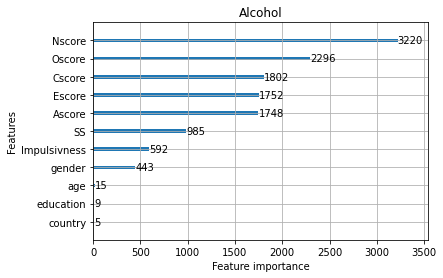

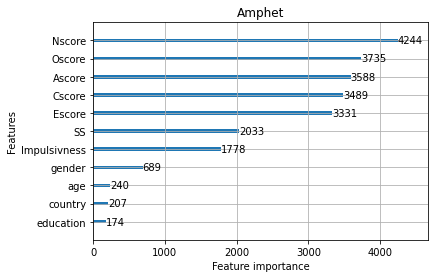

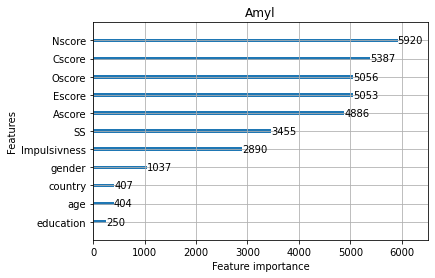

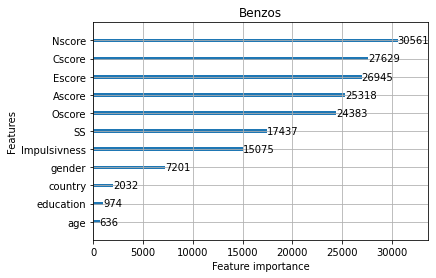

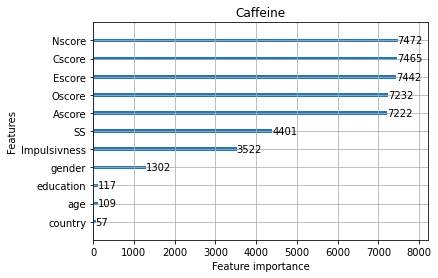

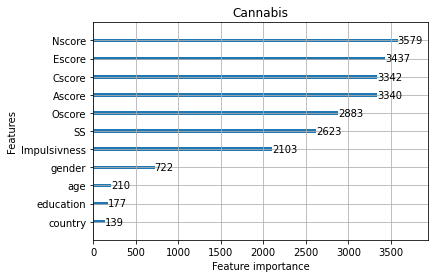

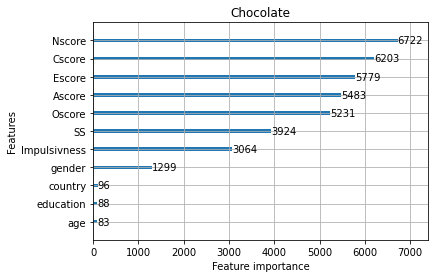

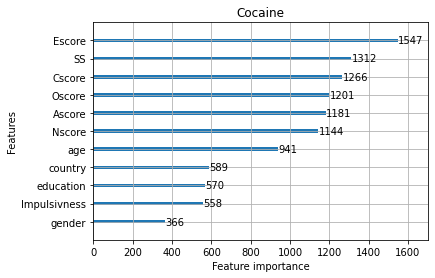

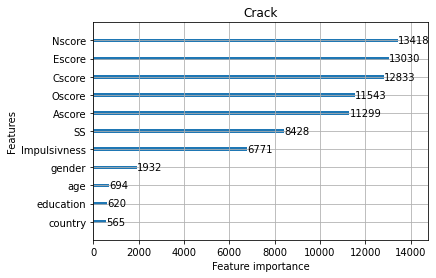

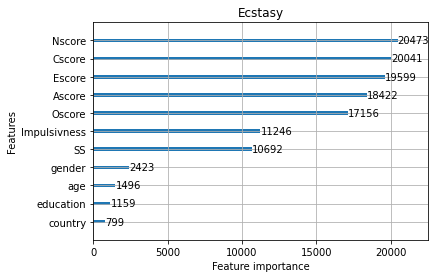

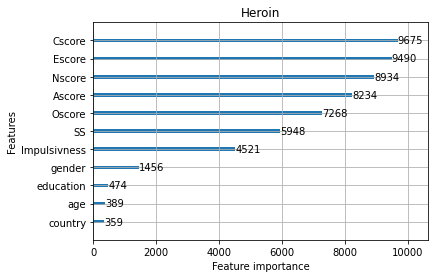

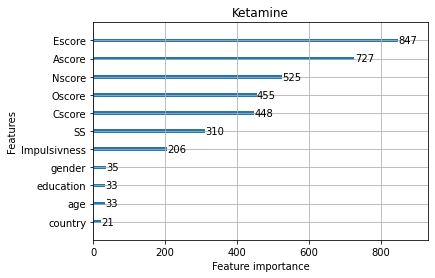

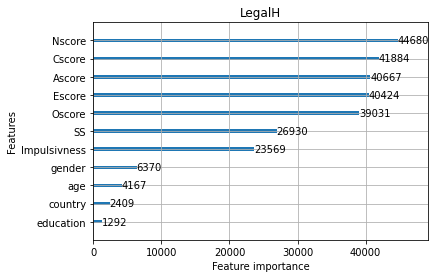

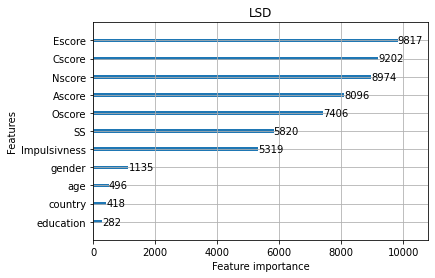

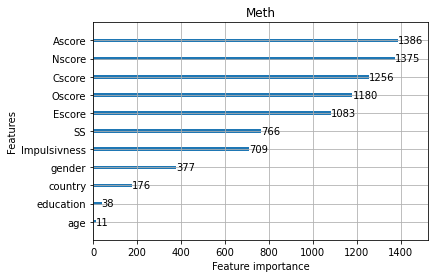

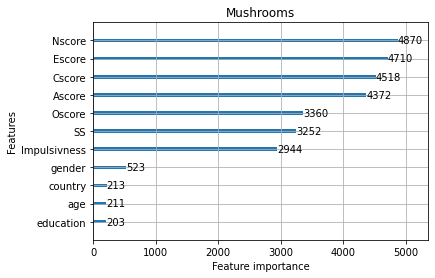

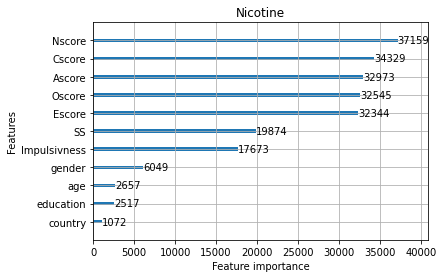

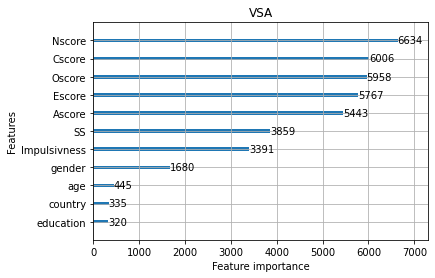

In [69]:
with open("/content/drive/MyDrive/Colab Notebooks/lgbm_drug_cons.pickle", 'rb') as drug_file:
  lgbm_parameters = pickle.load(drug_file)

types = {'num_leaves':'int', 'n_estimators':'int', 'boosting':['dart', 'gbdt']}
general = {'class_weight' : 'balanced', 'categorical_feature' : 'auto'}
lgbm = MultiLabelModel(LGBMClassifier, lgbm_parameters, types, general)
lgbm.fit(X_train_cat, y_train)

for i, drug in enumerate(y_train.columns):
  plot_importance(lgbm.models[i], title=drug)

Видно, что у психологических признаков важность намного выше, чем у остальных, проверим, как изменится качество, если обучить SVM только на этих психологических признаках

In [52]:
X_train_cut = X_train_ohe.iloc[:,:7]
X_train_cut.head()

,Nscore,Escore,Oscore,Ascore,Cscore,Impulsivness,SS
0,,,,,,,
90,0.91093,-0.57545,0.29338,-0.60633,-0.27607,0.52975,-0.21575
983,1.02119,1.11406,-1.11902,-0.91699,-1.01450,0.88113,1.22470
670,-0.58016,0.96248,0.44585,-0.30172,-0.14277,0.19268,0.76540
1551,-0.46725,0.00332,-1.11902,0.28783,-0.00665,0.19268,-0.52593
1373,1.23461,0.16767,0.58331,-0.30172,-1.25773,-1.37983,-0.21575


In [54]:
def qual_svc(params):
    model = SVC(class_weight='balanced', kernel='rbf', **params)
    return -np.mean(cross_val_score(model, X_train_cut, y_tar, 
                           scoring='f1', cv=3))

svc_grid = {'C' : hp.loguniform('C', -5, -2),
            'gamma' : hp.loguniform('gamma', -7, 5)}

svc_cut_parameters = []
for i in range(y_train.shape[1]):
  y_tar = y_train.iloc[:,i]
  best = fmin(fn=qual_svc, space=svc_grid, algo=tpe.suggest,
              max_evals=50, verbose=1)
  svc_cut_parameters.append(best)

100%|██████████| 50/50 [00:14<00:00,  3.44it/s, best loss: -0.3334250578576346]


In [55]:
general = {'class_weight' : 'balanced', 'kernel' : 'rbf'}

svc_cut = MultiLabelModel(SVC, svc_parameters, None, general)
svc_cut.cv_score(X_train_cut, y_train)

0.7790191911923474

Видно, что качество чуть уменьшилось, значит остальные признаки тоже несли часть важной информации

# Выводы

- Для данной задачи достигнуто средневзвешенное значение Recall **81%**
- Отдельно для каждого препарата Recall не ниже **69%**, а качество классификации не ниже **63%**
- Данная модель может быть использована, как один из способов проверки кандидатов на важную должность, т.к. она дает довольно хорошее качество для данной специфичной задачи
- На риск зависимости от различных препаратов больше влияют псхологические признаки, чем пол, возраст, страна проживания и образование

# Что можно улучшить

- В дальнейшем можно попробовать использовать для разных целевых признаков алгоритмы из разных семейств, а не из одного